In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

import astropy
from astropy import units as u
from astropy.table import Table
from astropy.time import Time

import lightkurve as lk

from tqdm import tqdm_notebook

import glob, os

import tensorflow as tf

plt.rcParams['font.size'] = 20

import exoplanet as xo


# Z Indi Data Analysis

A notebook to study the interesting eclipsing binary Z Indi.

First, download the data using `lightkurve`:

In [40]:
name = "Z Ind"
search = lk.search_lightcurvefile("Z Ind",exptime=120)

/var/folders/q3/wlh9qxyn1nxdm7v7l30qryf00000gn/T/ipykernel_44050/3827273588.py:2: LightkurveDeprecationWarning: The search_lightcurvefile function is deprecated and may be removed in a future version.
        Use search_lightcurve() instead.
  search = lk.search_lightcurvefile("Z Ind",exptime=120)


Plot it:

<AxesSubplot:xlabel='Time - 2457000 [BTJD days]', ylabel='Normalized Flux'>

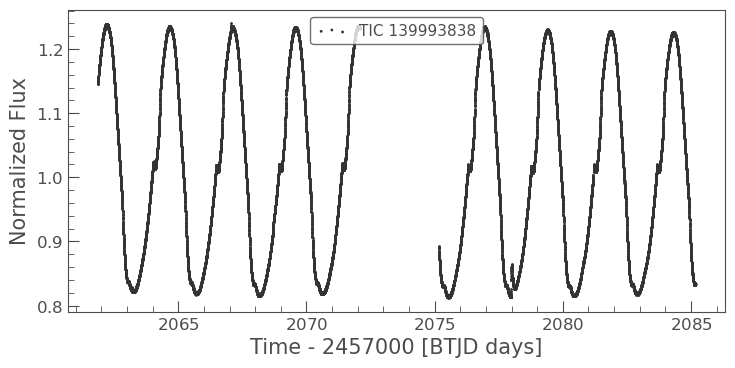

In [41]:
lc = search[0].download().remove_nans().remove_outliers().normalize()
lc = lc[lc.quality == 0]
lc.scatter()
# plt.axvline(2064.2 + 2.4639548974948435)
# plt.xlim(2063,2065)
# plt.xlim(2064,2067)


We can see a high amplitude periodic variation, with little dips. I wonder what those are?

(0.95, 1.02)

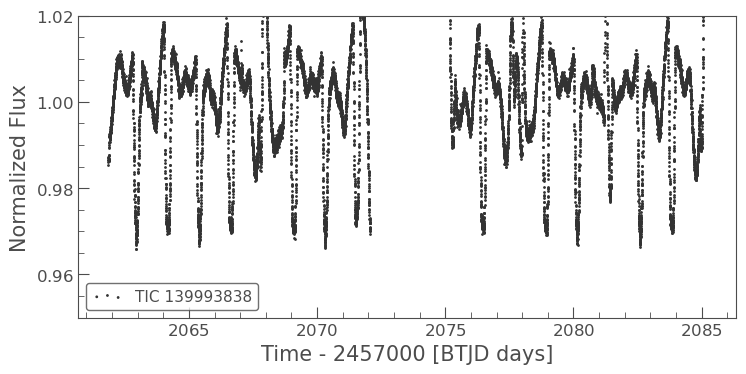

In [42]:
lc.flatten(window_length=800).scatter()
plt.ylim(0.95,1.02)


Eclipses! Let's try and nail down the frequency so we can fold the light curve.

Best period: 2.4639548974948435 d
Best frequency: 0.405851584790258 1 / d


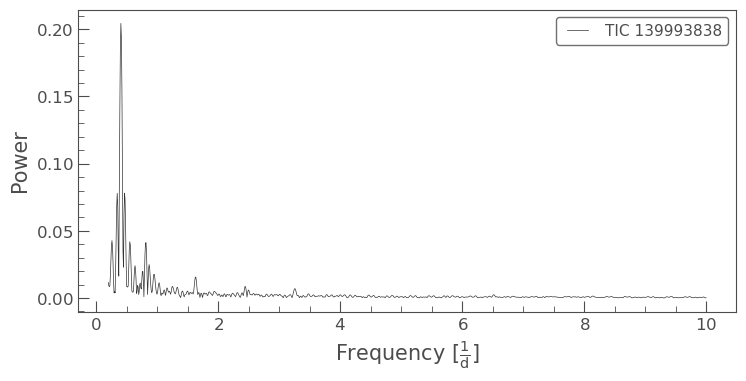

In [43]:
pg = lc.to_periodogram(minimum_frequency=0.2,maximum_frequency=10)
pg.plot()
print('Best period:',pg.period_at_max_power.to(u.d))
print('Best frequency:',pg.frequency_at_max_power)

Let's try and fit out the periodic variations using a GP.

In [44]:
x = np.ascontiguousarray(lc.time.value, dtype=np.float64)
y = np.ascontiguousarray(lc.flux, dtype=np.float64)
yerr = np.ascontiguousarray(lc.flux_err, dtype=np.float64)
texp = np.median(np.diff(x))


In [45]:
# Normalize around zero for GP fitting.  Keep in units of relative flux, rather
# than say ppt.
mu = np.nanmedian(y)
y = y / mu - 1
yerr = yerr / mu


In [46]:
import pymc3 as pm
import pymc3_ext as pmx
import aesara_theano_fallback.tensor as tt
from celerite2.theano import terms, GaussianProcess

from astropy import units as units, constants as const


In [47]:
# solar units
rstar = 35.9
Mstar = 2.6

# si units
Msun = 1.98847e30 # kg
Rsun = 696340e3 # km
G = 6.67430e-11 # si

# cgs units
Msun = 1.98847e30*1e3 # g
Rsun = 696340e3*1e2 # cm
G = 6.67430e-8 # cgs

logg_star = np.log10(G*Mstar*Msun/(rstar*Rsun)**2)
g_sun = G*Msun/Rsun**2
logg_sun = np.log10(g_sun)


In [48]:
logg_star

1.742066531336291

We'll fit a combination of an exactly periodic Lomb-Scargle (with several terms to account for higher harmonics), mask the eclipses that stick out, and fit an interpolation over the eclipses using a Gaussian Process.

In [16]:
from astropy.timeseries import LombScargle

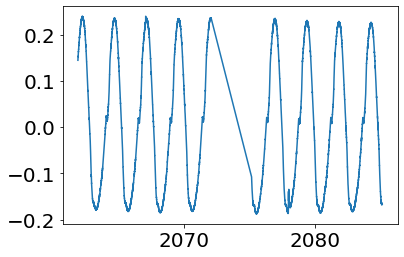

In [17]:
plt.plot(x,y)

Use a Lomb-Scargle to fit a sum of sine waves:

In [18]:
LS = LombScargle(x,y,yerr,nterms=2)

In [19]:
freqs = np.linspace(1/3,1/2,10000)
power = LS.power(freqs)
# plt.plot(1/freqs,power)
period = 1/freqs[np.argmax(power)]
print(period,'d')


2.4562538382804506 d


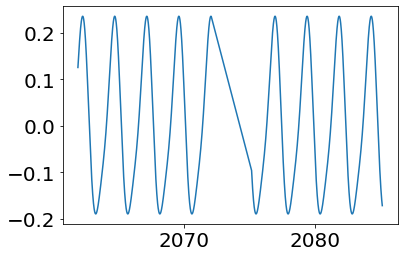

In [20]:
model = LS.model(x,freqs[np.argmax(power)])
plt.plot(x,model)


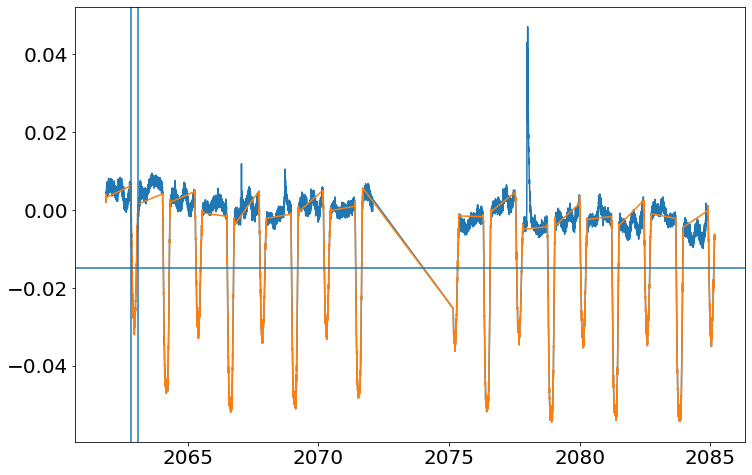

In [107]:
fig = plt.figure(figsize=(12.0,8.0))
t0 = 2062.95
dur = 0.15

m = (((x-t0) % (period/2))<(dur)) + (((x-t0) % (period/2)) > (period/2-dur))

plt.plot(x,y-model)
plt.plot(x[m],(y-model)[m])
plt.axhline(-0.015)
# plt.plot(x,model)
# plt.xlim(2060,2065)

plt.axvline(t0-0.12)
plt.axvline(t0+0.12)


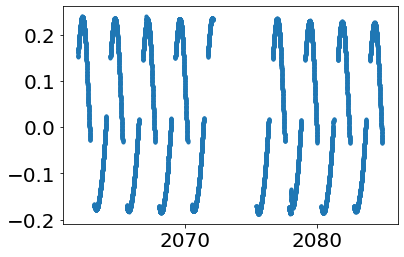

In [52]:
plt.plot(x[~m],y[~m],'.')


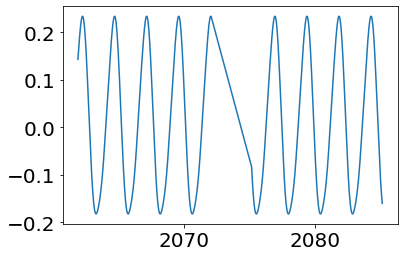

In [53]:
LS = LombScargle(x[~m],y[~m],yerr[~m],nterms=4)
model = LS.model(x,1/period)
plt.plot(x,model)

In [54]:
def normalize(xx):
    return (xx-xx.min())/(xx.max()-xx.min())

basis = np.vander(normalize(x[~m]),3)
soln = np.linalg.lstsq(basis,(y-model)[~m])
# help(np.linalg.lstsq)
coeffs = soln[0]
newbasis = np.vander(normalize(x),3)
trend = np.dot(newbasis,coeffs)


/var/folders/q3/wlh9qxyn1nxdm7v7l30qryf00000gn/T/ipykernel_44050/2710143171.py:5: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  soln = np.linalg.lstsq(basis,(y-model)[~m])


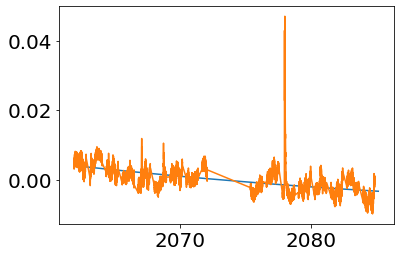

In [55]:
plt.plot(x,trend)
plt.plot(x[~m],(y-model)[~m])

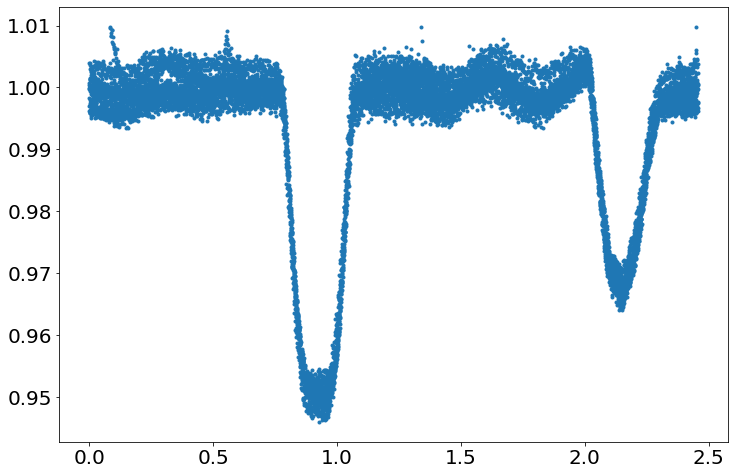

In [56]:
plt.figure(figsize=(12.0,8.0))
flare = (y-model-trend)>0.01
plt.plot((x % period)[~flare], (y-model-trend)[~flare]+1,'.')

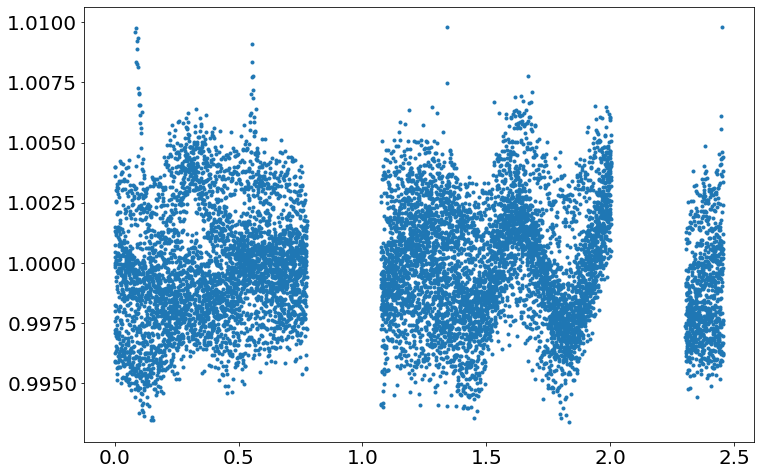

In [84]:
plt.figure(figsize=(12.0,8.0))
flare = (y-model-trend)>0.01
plt.plot((x % period)[~m*~flare], (y-model-trend)[~m*~flare]+1,'.')

Can we fit this with a GP?

In [58]:
import celerite2
from celerite2 import terms

# Quasi-periodic term
# term1 = terms.SHOTerm(sigma=1.0, rho=1.0, tau=10.0)

# Non-periodic component
term2 = terms.Matern32Term(sigma=0.005, rho=2.0)
kernel = term2

# Setup the GP
gp = celerite2.GaussianProcess(kernel, mean=0.0)
gp.compute(x[~m], yerr=yerr[~m])


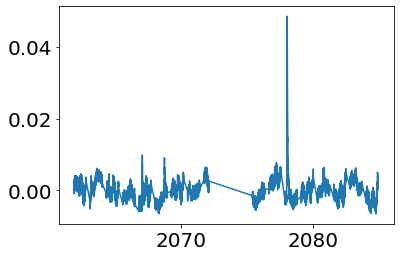

In [65]:
t = x[~m]
newy = (y-model-trend)[~m]
newyerr = yerr[~m]
plt.plot(t,newy)

In [66]:
from scipy.optimize import minimize


def set_params(params, gp):
    gp.mean = params[0]
    theta = np.exp(params[1:])
    gp.kernel = terms.Matern32Term(
        sigma=theta[0], rho=theta[1],
    ) 
    gp.compute(t, diag=newyerr**2 + theta[2], quiet=True)
    return gp


def neg_log_like(params, gp):
    gp = set_params(params, gp)
    return -gp.log_likelihood(newy)


initial_params = [0.0, np.log(0.005), np.log(2.0), np.log(0.0001)]
soln = minimize(neg_log_like, initial_params, method="L-BFGS-B", args=(gp,))
opt_gp = set_params(soln.x, gp)
soln


      fun: -59291.24265536269
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([-1149.74536701, -3478.31666954,  -371.04837473, -2596.61588987])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 220
      nit: 11
     njev: 44
   status: 0
  success: True
        x: array([-8.11239741e-03, -3.87569685e+00, -1.96816440e+00, -1.74485444e+01])

In [122]:
hand_gp = set_params([-8.11239741e-03, -6, -1.96816440e+00, -1.74485444e+01], gp)


In [123]:
# mu, variance = opt_gp.predict(newy, t=x, return_var=True)
mu, variance = hand_gp.predict(newy, t=x, return_var=True)

In [145]:
from scipy.signal import savgol_filter as savgol

In [160]:
# interpolated = np.interp(x,t,savgol(newy,51,5))
interpolated = np.interp(x,t,gaussfilt(newy,10))

Text(0, 0.5, 'Normalized Flux')

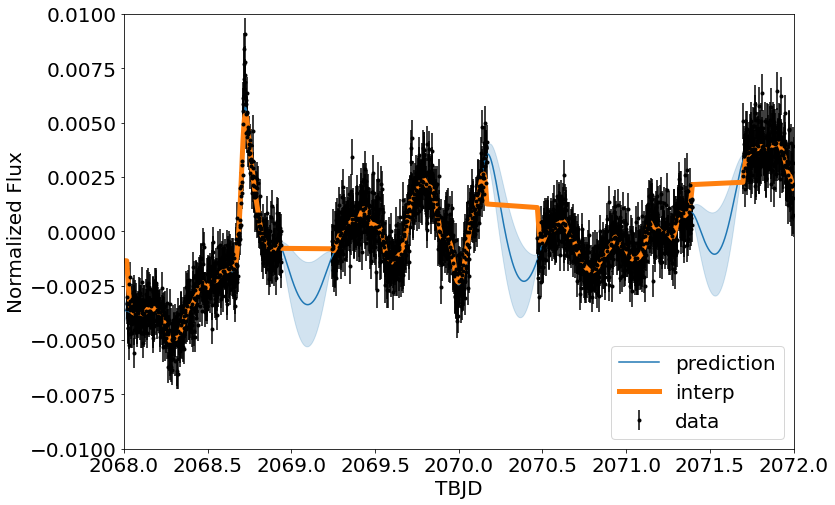

In [161]:
fig = plt.figure(figsize=(12.0,8.0))
plt.errorbar(t, newy, yerr=newyerr, fmt=".k", capsize=0, label="data")

sigma = np.sqrt(variance)
plt.plot(x, mu, label="prediction")
plt.plot(x, interpolated, label="interp",lw=5)

plt.fill_between(x, mu - sigma, mu + sigma, color="C0", alpha=0.2)
plt.ylim(-0.01,0.01)
plt.xlim(2068,2072)
plt.legend()

plt.xlabel('TBJD')
plt.ylabel('Normalized Flux')
# plt.savefig('z_ind_gp.png',bbox_inches='tight')

In [70]:
from scipy.ndimage.filters import gaussian_filter1d as gaussfilt

/var/folders/q3/wlh9qxyn1nxdm7v7l30qryf00000gn/T/ipykernel_44050/2359404833.py:1: DeprecationWarning: Please use `gaussian_filter1d` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter1d as gaussfilt


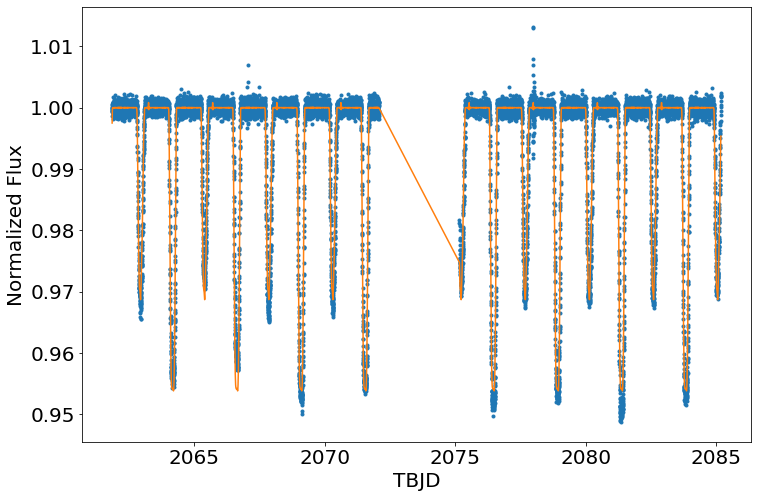

In [72]:
fig = plt.figure(figsize=(12.0,8.0))

t_folded = (x % period)#[~flare]

t_base = (x)
args = np.argsort(t_folded)
t_folded = t_folded
y_unfolded = ((y-model-trend)+1 - mu)

args = np.argsort(t_folded)
t_folded = t_folded[args]
y_folded = ((y-model-trend)+1 - mu)[args]
smooth = gaussfilt(y_folded,30)

plt.plot(t_base, y_unfolded,'.')
plt.plot(t_base, smooth[np.argsort(args)],'-')

plt.xlabel('TBJD')
plt.ylabel('Normalized Flux')
plt.savefig('z_ind_eclipses.png',bbox_inches='tight')

Text(0, 0.5, 'Normalized Flux')

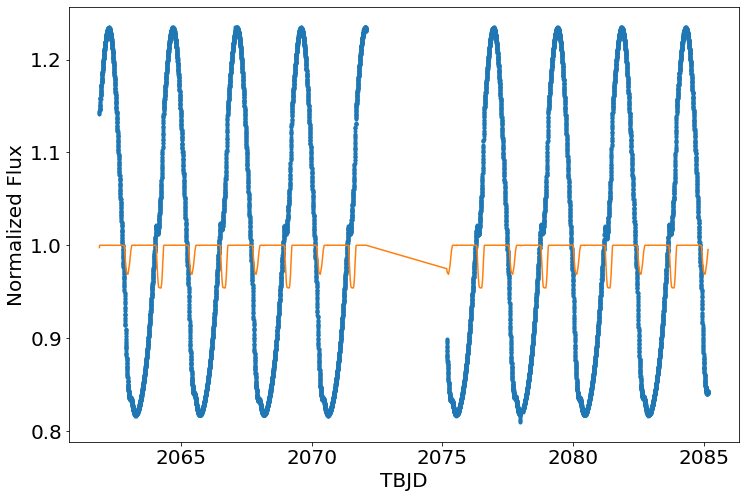

In [73]:
fig = plt.figure(figsize=(12.0,8.0))

t_base = (x)[~flare]
args = np.argsort(t_folded)
t_folded = t_folded
y_unfolded = ((y-trend)+1 - mu)[~flare]

t_folded = (x % period)[~flare]
args = np.argsort(t_folded)
t_folded = t_folded[args]
y_folded = ((y-model-trend)+1 - mu)[~flare][args]
smooth = gaussfilt(y_folded,30)

plt.plot(t_base, y_unfolded,'.')
plt.plot(t_base, smooth[np.argsort(args)],'-')

plt.xlabel('TBJD')
plt.ylabel('Normalized Flux')
# plt.savefig('z_ind_eclipses.png',bbox_inches='tight')

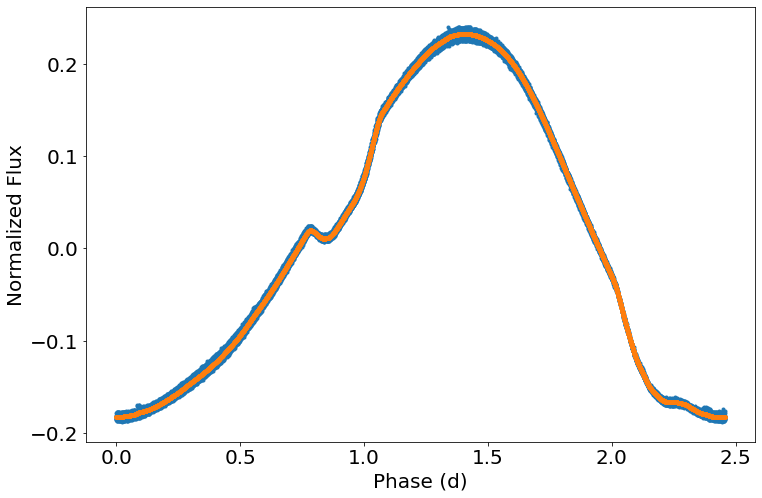

In [85]:
fig = plt.figure(figsize=(12.0,8.0))

t_folded = (x % period)[~flare]
args = np.argsort(t_folded)
t_folded = t_folded[args]
y_folded = (y)[~flare][args]
smooth = gaussfilt(y_folded,30)

plt.plot(t_folded, y_folded,'.')
plt.plot(t_folded, smooth,'.')
plt.xlabel('Phase (d)')
plt.ylabel('Normalized Flux')
plt.savefig('z_ind_folded.png',bbox_inches='tight')
# plt.axvline(0.925)
# plt.axvline(0.925+period/2)

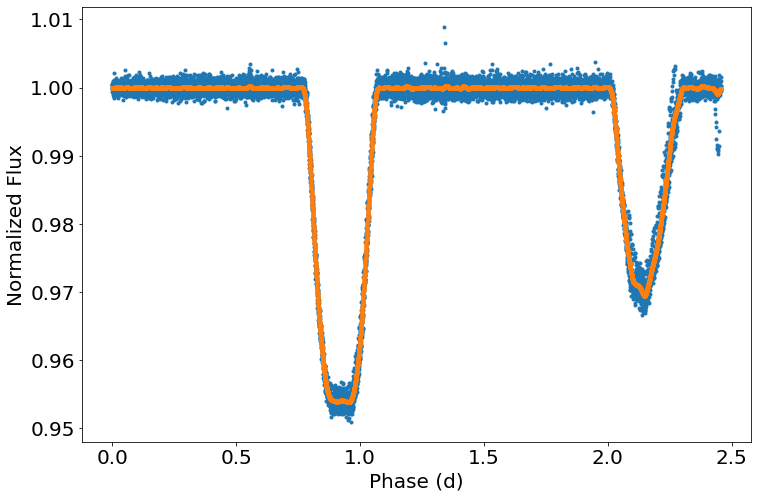

In [156]:
fig = plt.figure(figsize=(12.0,8.0))

t_folded = (x % period)[~flare]
args = np.argsort(t_folded)
t_folded = t_folded[args]
y_folded = ((y-model-trend)+1 - mu)[~flare][args]
smooth = gaussfilt(y_folded,30)

plt.plot(t_folded, y_folded,'.')
plt.plot(t_folded, smooth,'.')
plt.xlabel('Phase (d)')
plt.ylabel('Normalized Flux')
plt.savefig('z_ind_folded.png',bbox_inches='tight')
# plt.axvline(0.925)
# plt.axvline(0.925+period/2)

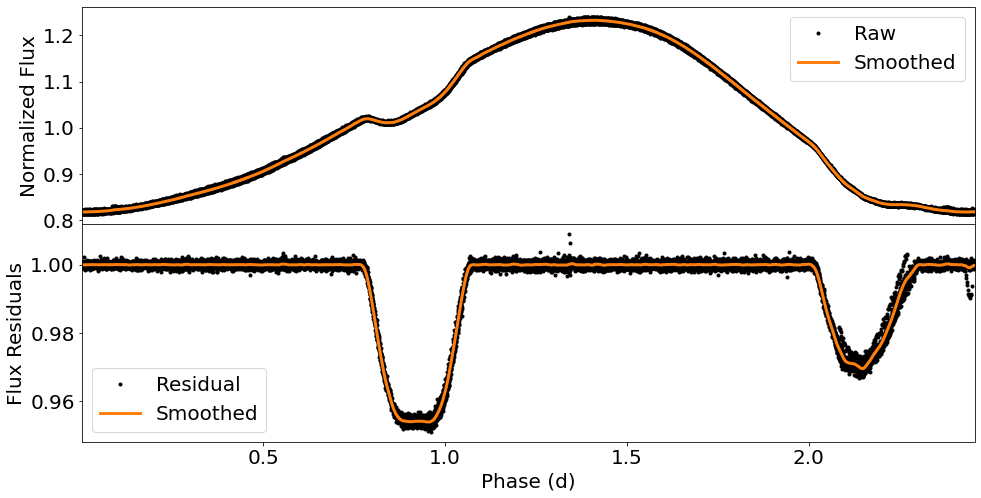

In [168]:
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(16.0,8.0),sharex=True)

# unfiltered
t_folded = (x % period)[~flare]
args = np.argsort(t_folded)
t_folded = t_folded[args]

y_folded = (y+1)[~flare][args]
y2_folded = ((y-model-trend)+1 - mu)[~flare][args]
# y2_folded = ((y-model-trend)+1 - interpolated)[~flare][args]


smooth = gaussfilt(y_folded,30)
smooth2 = gaussfilt(y2_folded,30)
# smooth3 = gaussfilt(y3_folded,30)


lw = 3
ax1.plot(t_folded, y_folded,'.k',label='Raw')
ax1.plot(t_folded, smooth,'-',label='Smoothed',lw=lw,color='C1')
ax2.plot(t_folded, y2_folded,'.k',label='Residual')
ax2.plot(t_folded, smooth2,'-',label='Smoothed',lw=lw,color='C1')
# ax2.plot(t_folded, smooth3,'-',label='Smoothed Interp',lw=lw,color='C2')

ax2.set_xlabel('Phase (d)')
ax1.set_ylabel('Normalized Flux')
ax2.set_ylabel('Flux Residuals')

ax1.set_xticks([0.5, 1.0, 1.5,2.0])
ax2.set_xticks([0.5, 1.0, 1.5,2.0])

ax1.legend()
ax2.legend()

ax2.set_xlim(t_folded.min(),t_folded.max())
fig.subplots_adjust(hspace=0)

ax1.set_rasterized(True)
ax2.set_rasterized(True)

plt.savefig('z_ind_folded_both.png',bbox_inches='tight')
plt.savefig('z_ind_folded_both.pdf',bbox_inches='tight')
# plt.axvline(0.925)
# plt.axvline(0.925+period/2)

Wow! What is happening here? Let's look at the implied stellar radii.

In [75]:
depth = (1-np.min(smooth))
print('Deeper eclipse is %.1f%%' % (depth*100))
print('Implies stellar radius of %.1f Rsun' % (np.sqrt(depth)*rstar))

depth = (1-np.min(smooth[t_folded>1.5]))
print('Shallower eclipse is %.1f%%' % (depth*100))
print('Implies stellar radius of %.1f Rsun' % (np.sqrt(depth)*rstar))

Deeper eclipse is 4.6%
Implies stellar radius of 7.7 Rsun
Shallower eclipse is 3.1%
Implies stellar radius of 6.4 Rsun


In [76]:
print('If a dwarf')
print('Implies stellar radius of %.2f Rsun' % (np.sqrt(depth)*0.783))
print('Implies stellar radius of %.2f Rearth' % (np.sqrt(depth)*0.783*109))


If a dwarf
Implies stellar radius of 0.14 Rsun
Implies stellar radius of 15.10 Rearth


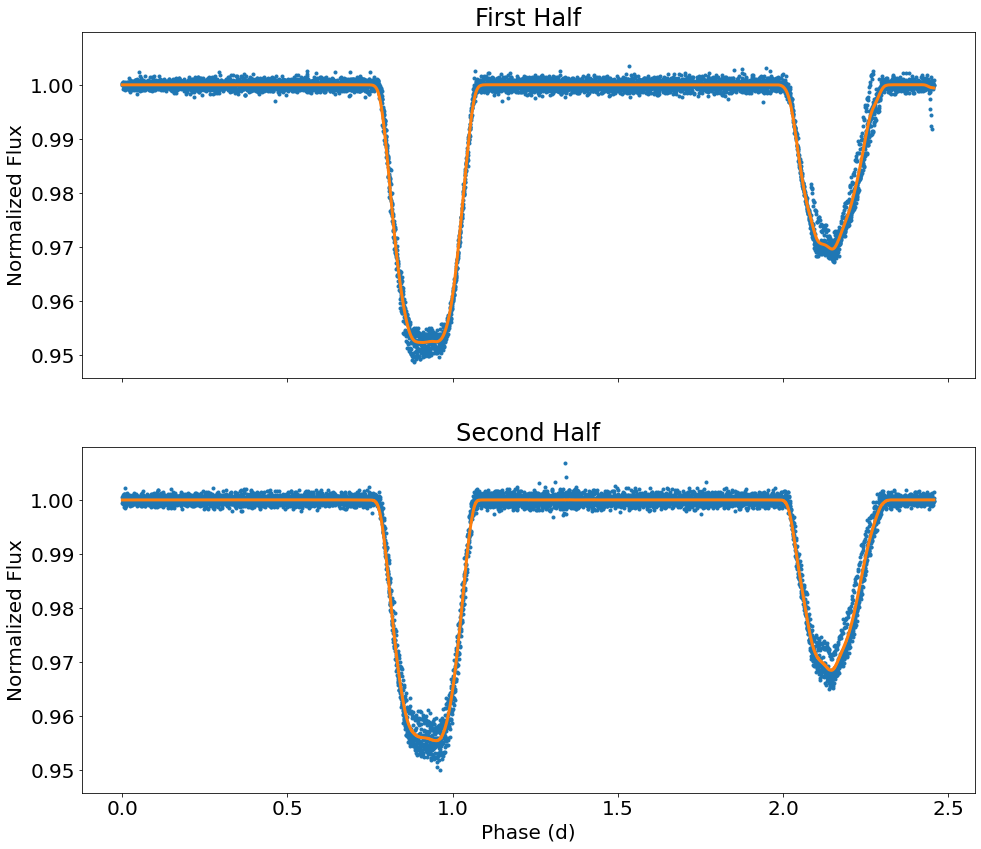

In [77]:
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(16.0,14.0),sharey=True,sharex=True)

first = normalize(x[~flare])>0.5 
t_folded = (x % period)[~flare][first]
args = np.argsort(t_folded)
t_folded = t_folded[args]
y_folded = ((y-model-trend)+1 - mu)[~flare][first][args]
smooth = gaussfilt(y_folded,30)

ax1.plot(t_folded, y_folded,'.')
ax1.plot(t_folded, smooth,'-',lw=3)
ax1.set_title('First Half')

t_folded = (x % period)[~flare][~first]
args = np.argsort(t_folded)
t_folded = t_folded[args]
y_folded = ((y-model-trend)+1 - mu)[~flare][~first][args]
smooth = gaussfilt(y_folded,30)

ax2.plot(t_folded, y_folded,'.')
ax2.plot(t_folded, smooth,'-',lw=3)
ax2.set_title('Second Half')

ax2.set_xlabel('Phase (d)')
ax1.set_ylabel('Normalized Flux')
ax2.set_ylabel('Normalized Flux')

plt.savefig('z_ind_2_halves.png',bbox_inches='tight')

In [78]:
tpfsearch = lk.search_targetpixelfile('Z Ind',exptime=120)
tpf = tpfsearch.download()

<AxesSubplot:title={'center':'Target ID: 139993838, Cadence: 600765'}, xlabel='Pixel Column Number', ylabel='Pixel Row Number'>

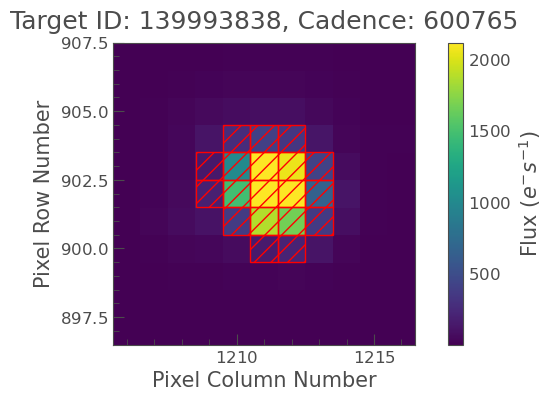

In [79]:
tpf.plot(aperture_mask='pipeline')

In [ ]:
help(tpf.plot)

Help on method plot in module lightkurve.targetpixelfile:

plot(ax=None, frame=0, cadenceno=None, bkg=False, column='FLUX', aperture_mask=None, show_colorbar=True, mask_color='red', title=None, style='lightkurve', **kwargs) method of lightkurve.targetpixelfile.TessTargetPixelFile instance
    Plot the pixel data for a single frame (i.e. at a single time).
    
    The time can be specified by frame index number (`frame=0` will show the
    first frame) or absolute cadence number (`cadenceno`).
    
    Parameters
    ----------
    ax : `~matplotlib.axes.Axes`
        A matplotlib axes object to plot into. If no axes is provided,
        a new one will be generated.
    frame : int
        Frame number. The default is 0, i.e. the first frame.
    cadenceno : int, optional
        Alternatively, a cadence number can be provided.
        This argument has priority over frame number.
    bkg : bool
        If True and `column="FLUX"`, background will be added to the pixel values.
    colu